# Gold Price Prediction

In [59]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
sns.set_style("darkgrid", {"grid.color": ".6",
                           "grid.linestyle": ":"})

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [60]:
dataset = pd.read_csv("/content/gold_price_data.csv",
                      parse_dates=["Date"])

In [61]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     2290 non-null   datetime64[ns]
 1   SPX      2290 non-null   float64       
 2   GLD      2290 non-null   float64       
 3   USO      2290 non-null   float64       
 4   SLV      2290 non-null   float64       
 5   EUR/USD  2290 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 107.5 KB


In [62]:
dataset.isna().sum().sort_values(ascending=False)

,0
Date,0
SPX,0
GLD,0
USO,0
SLV,0
EUR/USD,0


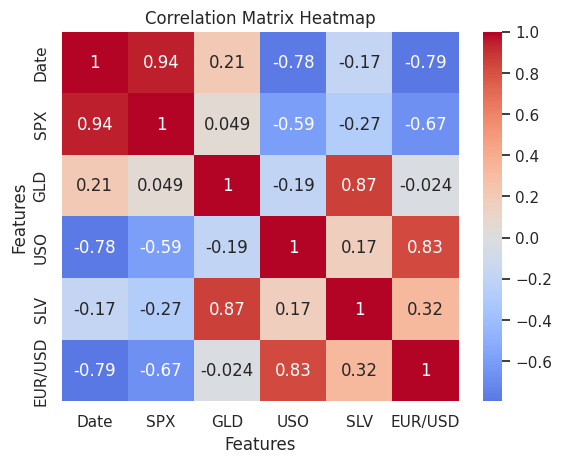

In [63]:
correlation  = dataset.corr()

sns.heatmap(correlation, cmap='coolwarm',
            center=0, annot=True)

plt.title('Correlation Matrix Heatmap')
plt.xlabel('Features')
plt.ylabel('Features')

plt.show()

In [64]:
dataset.drop("SLV", axis=1,
             inplace=True)

In [65]:
dataset.set_index("Date", inplace=True)

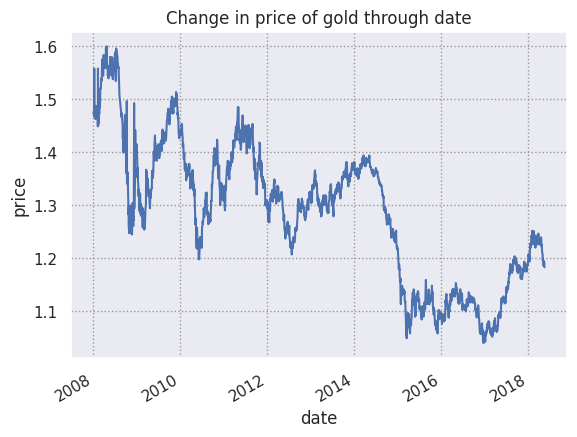

In [66]:
dataset["EUR/USD"].plot()
plt.title("Change in price of gold through date")
plt.xlabel("date")
plt.ylabel("price")
plt.show()

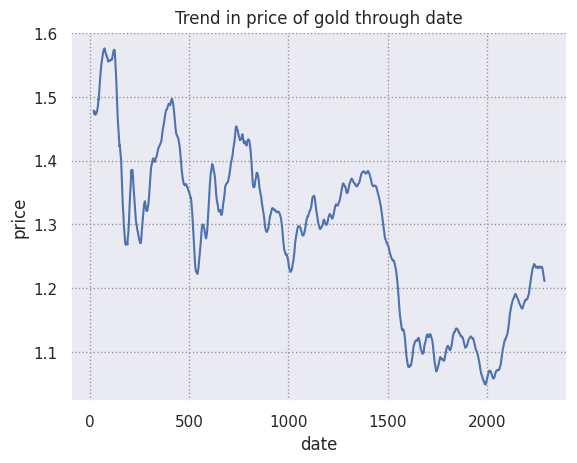

In [67]:
dataset["price_trend"] = dataset["EUR/USD"]\
    .rolling(window=20).mean()

dataset.reset_index("Date", inplace=True)

dataset["price_trend"].loc[20:].plot()

plt.title("Trend in price of gold through date")

plt.xlabel("date")
plt.ylabel("price")
plt.show()

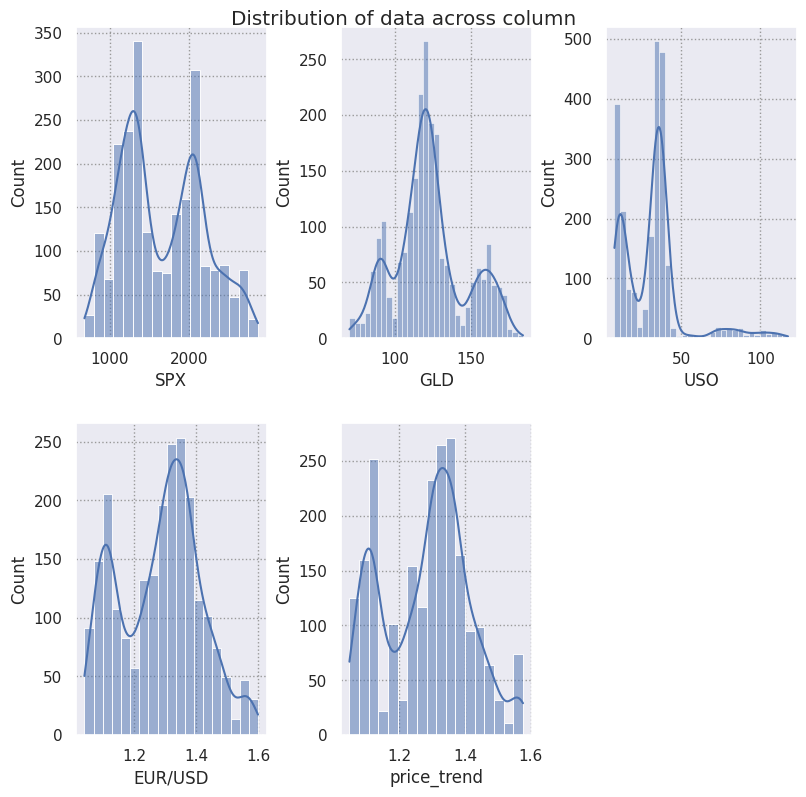

In [68]:
fig = plt.figure(figsize=(8, 8))

fig.suptitle('Distribution of data across column')
temp = dataset.drop("Date", axis=1).columns.tolist()
for i, item in enumerate(temp):
    plt.subplot(2, 3, i+1)
    sns.histplot(data=dataset, x=item, kde=True)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
plt.show()

In [69]:
print(dataset.drop("Date", axis=1).skew(axis=0, skipna=True))

SPX            0.300362
GLD            0.334138
USO            1.699331
EUR/USD       -0.005292
price_trend   -0.029588
dtype: float64


In [70]:
dataset["USO"] = dataset["USO"]\
    .apply(lambda x: np.sqrt(x))

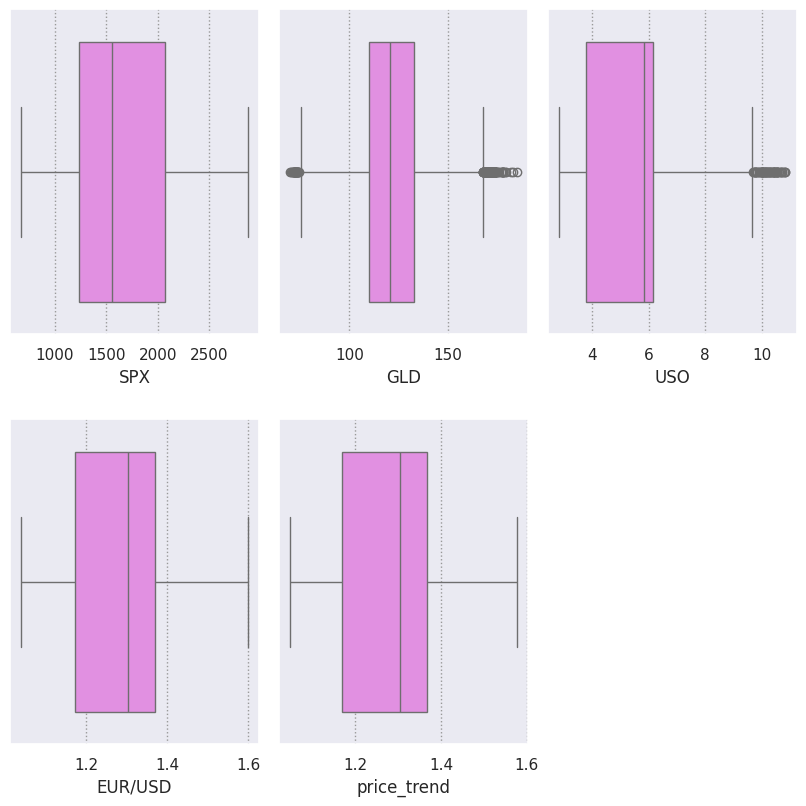

In [71]:
fig = plt.figure(figsize=(8, 8))
temp = dataset.drop("Date", axis=1).columns.tolist()
for i, item in enumerate(temp):
    plt.subplot(2, 3, i+1)
    sns.boxplot(data=dataset, x=item, color='violet')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
plt.show()

In [72]:
def outlier_removal(column):
    upper_limit = column.quantile(.95)
    lower_limit = column.quantile(.05)
    column.loc[(column > upper_limit)] = upper_limit
    column.loc[(column < lower_limit)] = lower_limit
    return column

In [73]:
dataset[['SPX', 'GLD', 'USO', 'EUR/USD']] = \
    dataset[['SPX', 'GLD', 'USO', 'EUR/USD']].apply(outlier_removal)

In [74]:
X = dataset.drop(['Date', 'EUR/USD'], axis=1)

y = dataset['EUR/USD']
x_train, x_test,\
    y_train, y_test = train_test_split(X, y,
                                       test_size=0.2)

In [75]:
scaler = StandardScaler()

scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [76]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')

x_train_scaled = imputer.fit_transform(x_train_scaled)

x_test_scaled = imputer.transform(x_test_scaled)

poly = PolynomialFeatures(degree=2)

lasso = Lasso()

param_grid = {'lasso__alpha': [1e-4, 1e-3, 1e-2,
							1e-1, 1, 5, 10,
							20, 30, 40]}

pipeline = make_pipeline(poly, lasso)

lasso_grid_search = GridSearchCV(pipeline,
								param_grid,
								scoring='r2', cv=3)

lasso_grid_search.fit(x_train_scaled, y_train)

y_pred = lasso_grid_search.predict(x_train_scaled)

r2 = r2_score(y_train, y_pred)

print("R-squared: ", r2)

print('Best parameter values: ',
	lasso_grid_search.best_params_)
print('Best score: ',
	lasso_grid_search.best_score_)

R-squared:  0.9659497046938251
Best parameter values:  {'lasso__alpha': 0.0001}
Best score:  0.9644354471710538


In [77]:
param_grid = {'n_estimators': [50, 80, 100],
              'max_depth': [3, 5, 7]}

rf = RandomForestRegressor()

rf_grid_search = GridSearchCV(rf, param_grid, scoring='r2', cv=2)


rf_grid_search.fit(x_train_scaled, y_train)

print('Best parameter values: ', rf_grid_search.best_params_)
print('Best score: ', rf_grid_search.best_score_)

Best parameter values:  {'max_depth': 7, 'n_estimators': 80}
Best score:  0.9762621048184232


In [78]:
r2 = r2_score(y_test,
              rf_grid_search.predict(x_test_scaled))

print("R-squared:", r2)

R-squared: 0.9779021318229856


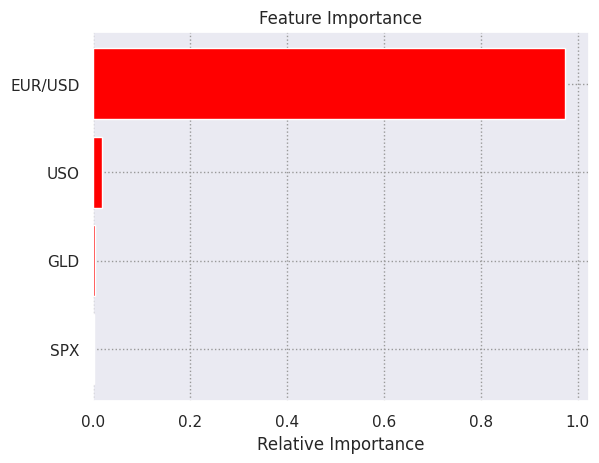

In [79]:
features = dataset.drop("Date", axis=1).columns

importances = rf_grid_search.best_estimator_.\
    feature_importances_


indices = np.argsort(importances)

plt.title('Feature Importance')

plt.barh(range(len(indices)),
         importances[indices],
         color='red',
         align='center')

plt.yticks(range(len(indices)),
           [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [80]:
model_xgb = XGBRegressor()

model_xgb.fit(x_train_scaled, y_train)

print("Xgboost Accuracy =", r2_score(
    y_train, model_xgb.predict(x_train_scaled)))

Xgboost Accuracy = 0.9994451377712423


In [81]:
print("Xgboost Accuracy on test data =",
      r2_score(y_test,
               model_xgb.predict(x_test_scaled)))

Xgboost Accuracy on test data = 0.9830259986768435


In [83]:
!pip install eli5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.4/108.4 kB 4.2 MB/s eta 0:00:00


In [84]:
import eli5 as eli
feature_names = x_train.columns.tolist()

eli.explain_weights(model_xgb, feature_names=feature_names)

Weight,Feature
0.9620,price_trend
0.0235,USO
0.0091,GLD
0.0055,SPX


In [85]:
import pickle

pickle.dump(model_xgb, open('model.pkl', 'wb'))